In [2]:
import numpy as np
import matplotlib.pyplot as plt


In [3]:
def power_to_dB(x, x0=1, round_decimals=True):
    """ 
    Converts power units (parts, not Watts) to the corresponding dB (Decibel) value.
    numpy.abs() function is wrapped arround the return value since the funcion is intended to convert optical extinction ratio to dB units.   
    Args: 
        * x (float): a value to be converted. 
        * x0 (float): a reference zero value from wich the dB ratio will be calculated.
        * round_decimals (bool): rounds decimals of the returned value if set to True, leaves the return unrounded if set to False.
    Returns:
        * x_dB (float): dB ratio of powers. 
    """
    x_dB = 10 * np.log10(x / x0)
    if round_decimals:
        x_dB = np.round(x_dB)
    return np.abs(x_dB)



def sum_kernel(loss, intensity_array, j, k, k_stop):
    """
    Calculates the kernel sum of the product of optical loss and corresponding output intensity.
    Args: 
        * loss (float): optical loss per cycle in range [0,1). 
        * intensity_array (array, float or int): desired output intensity pattern with values in range [0,1]. 
        * j (int): the j-th lower summation index.
        * k (int): the k-th summation index.
        * k_stop (int): the k-th upper summation index.
    Returns:
        * s (float): calculated kernel sum.
    """
    n = len(intensity_array)
    alpha = 1 - loss
    s = 0
    for i in range(j, n-k-k_stop):
        s += np.power(alpha, n-i-k) * intensity_array[i+k]
    return s



def calculate_first_transmittance(loss, t_n, intensity_array):
    """
    Calculates the first transmittance T(1,n) in the sequence of n transmittances.
    Args: 
        * loss (float): optical loss per cycle in range [0,1).
        * t_n  (float): the n-th (last) transmittance value. Strongly recommended to set equal to the extinction ratio of the EOM.  
        * intensity_array (array, float or int): desired output intensity pattern with values in range [0,1]. 
    Returns:
        * t (float): calculated first transmittance value.
    """    
    n = len(intensity_array)
    alpha = 1 - loss
    t = np.power(alpha, n) * intensity_array[0] * (t_n - 1) / (-sum_kernel(loss, intensity_array, j=0, k=0, k_stop=0) + t_n * sum_kernel(loss, intensity_array, j=0, k=0, k_stop=1))
    return t



def calculate_ith_transmittance(loss, t_n, intensity_array, j,k):
    """
    Calculates the i-th transmittances T(i,n) in the sequence of n transmittances.
    Args: 
        * loss (float): optical loss per cycle in range [0,1).
        * t_n  (float): the n-th (last) transmittance value. Strongly recommended to equal to the extinction ratio of the EOM.  
        * intensity_array (array, float or int): desired output intensity pattern with values in range [0,1].
        * j (int): the j-th lower summation index.
        * k (int): the k-th summation index.
    Returns:
        * t (float): calculated i-th transmittance value.
    """        
    t = (-sum_kernel(loss, intensity_array, j+1, k, k_stop=0) + t_n * sum_kernel(loss, intensity_array, j+1, k, k_stop=1)) / (-sum_kernel(loss, intensity_array, j, k, k_stop=0) + t_n * sum_kernel(loss, intensity_array, j, k, k_stop=1))
    return t



def calculate_transmittance_sequence(loss, t_n, intensity_array):
    """
    Calculates the full sequence of n transmittances that are needed to construct intensity pattern specified by *intensoty_array*.
    Args: 
        * loss (float): optical loss per cycle in range [0,1).
        * t_n  (float): the n-th (last) transmittance value. Strongly recommended to set equal to the extinction ratio of the EOM.  
        * intensity_array (array, float or int): desired output intensity pattern with values in range [0,1].
    Returns:
        * t (array, float): calculated sequence of n transmittance values.
    """        
    n = len(intensity_array)
    t = np.zeros(n)
    t[0] = calculate_first_transmittance(loss, t_n, intensity_array)
    t[n-1] = t_n
    if t[0] < t_n:
        print("Warning: the first transmittance value is below t_n (assuming t_n is set to the EOM extinction ratio)..." )
        print("Consider to reduce the number of output intensities (length of the intensity array).") 
    for i in range(1, n-1):
        t[i] = calculate_ith_transmittance(loss, t_n, intensity_array, j=0, k=i)
    return t



def calculate_intensity_sequence(loss, transmittance_array):
    """
    Calculates output intensities based on input transmittances array.
    Args:
        loss (float): optical loss per cycle in range [0,1)
        transmittance_array (array, float): sequence of n output transmittances.
    Returns: 
        intensity_arr (array, float): calcutated sequence of n intensities. 
    """ 
    intensity_arr = np.zeros(len(transmittance_array))
    for i in range(len(transmittance_array)):
        if i == 0:
             intensity_arr[0] = transmittance_array[0]
        else:
             intensity_arr[i] = (1 - transmittance_array[0]) * (1 - transmittance_array[i]) * np.power(1-loss, i) * np.prod(transmittance_array[1:i])
    return intensity_arr


def intensity_zero(I_0, loss, transmittance_array):
    """
    Calculates output intensities based on input transmittances array.
    Args:
        loss (float): optical loss per cycle in range [0,1)
        transmittance_array (array, float): sequence of n output transmittances.
    Returns: 
        intensity_arr (array, float): calcutated sequence of n intensities. 
    """ 
    intensity_arr = np.zeros(len(transmittance_array))
    for i in range(len(transmittance_array)):
        if i == 0:
             intensity_arr[0] = I_0 * transmittance_array[0]
        else:
             intensity_arr[i] = I_0 * (1 - transmittance_array[0]) * (1 - transmittance_array[i]) * np.power(1-loss, i) * np.prod(transmittance_array[1:i])
    return intensity_arr


def estimate_timebin_number(loss, ext_rt):
    """ 
    Estimates the maximal balanced time bin number for given optical loss and extinction ratio. 
    Args:
        * loss (float): optical loss per cycle in range [0,1).
        ext_rt (float): extinction ratio in rational form from range [0,1] (e.g. 1/200, 0.005, etc.)
    Returns:
        * n_bins(int): maximal time bin number.
    """
    n_bins = 1
    t_zero = calculate_first_transmittance(loss, ext_rt, np.ones(n_bins))
    while t_zero > ext_rt: 
        n_bins += 1
        t_zero = calculate_first_transmittance(loss, ext_rt, np.ones(n_bins))
        if t_zero < ext_rt: 
                break
    return n_bins-1



def transmittance_to_voltage(transmittance, ext_rt= 1/200, V_PI=450):
    """
    Calculates EOM voltage from given optical transmittance.
    Args:
        * transmittance (float): optical transmittace.
        * V_PI (float): half-wave voltage, in volts.
    Returns:
        * float: voltage value. 
    """
    return (2 * V_PI / np.pi) * np.arccos( np.sqrt((transmittance - ext_rt) / (1 - ext_rt)) )  



def voltage_to_transmittance(voltage,  ext_rt= 1/200, V_PI=450):
    """
    Calculates optical transmittance from given EOM voltage.
    Args:
        * voltage (float): EOM voltage
        * ext_rt (float): extinction ratio
        * V_PI (float): half-wave voltage, in volts
    Returns:
        * float: optical transmittance
    """    
    return np.cos(0.5 * np.pi * (voltage / V_PI))**2  * (1 - ext_rt) + ext_rt



def simulate_noisy_intensity(n_bins, loss, ext_rt, V_PI, voltage_err_cents, normalize_output=True):
    """ 
    Simulates balanced time bin intensity pattern in the presence of EOM voltage setting error (simulated as Gassian noise).
    Args:
        * n_bins (int): number of time bins. 
        * loss (float): optical loss per cycle in range [0,1).
        * extinction_ratio (float): extinction ratio of the EOM in rational form from range [0,1) (e.g. 1/200, 0.005, etc.).
        * voltage_err_cents (float, int): EOM voltage setting error in percencts (0-100) of the half-wave voltage. 
    Returns: 
        * noisy_intensity (array, float): normalized intensity pattern in the presence of voltage setting error.      
    """    
    intensity = np.ones(n_bins)
    voltage_error = 0.01 * voltage_err_cents * V_PI
    transmittance = calculate_transmittance_sequence(loss, ext_rt, intensity)
    noise = np.random.normal(0, voltage_error, n_bins)
    eom_voltage = transmittance_to_voltage(transmittance, ext_rt=ext_rt, V_PI=V_PI)
    noisy_voltage = eom_voltage + noise
    noisy_transmittance = voltage_to_transmittance(noisy_voltage, ext_rt=ext_rt, V_PI=V_PI)
    noisy_intensity = calculate_intensity_sequence(loss, noisy_transmittance)
    if normalize_output:
        noisy_intensity = noisy_intensity / np.mean(noisy_intensity)
    return noisy_intensity



def estimate_intensity_error(n_bins, loss, ext_rt, V_PI, voltage_err_cents, n_trials):
    """ 
    Estimates the mean std value of balanced time bin intensity pattern affected by EOM voltage setting error.
    Args:
        * n_bins (int): number of time bins in the intensity pattern.
        * loss (float): optical loss per cycle in range [0,1).
        * ext_rt (float): extinction ratio of the EOM in rational form from range [0,1) (e.g. 1/200, 0.005, etc).
        * V_PI (float): half-wave voltage of the EOM.
        * voltage_err_cents (float, int): EOM voltage setting error in percents(0-100) of the half-wave voltage.
        * n_trials (int): number of trials to estimate over.
    Returns: 
        * mean_intensity_std (float): mean std value of the noisy intensity over specified number of trials.
    """
    intensity_std = np.zeros(n_trials)
    for trial in range(n_trials):
        noisy_intensity = simulate_noisy_intensity(n_bins, loss, ext_rt, V_PI, voltage_err_cents, normalize_output=False)
        intensity_std[trial] = np.std(noisy_intensity) / np.mean(noisy_intensity)
    mean_intensity_std = np.mean(intensity_std)
    return mean_intensity_std




Maximal timebin number for input loss = 0.07 and extinction ratio = 0.005 is : 38


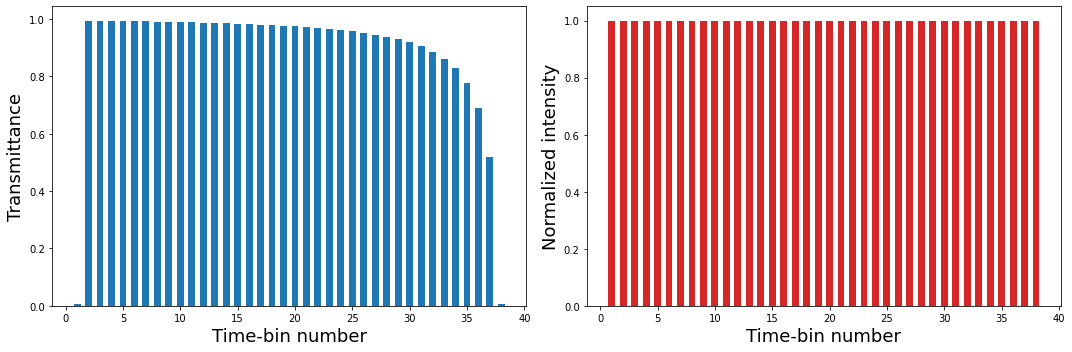

In [16]:
n_bins = 38
bins = range(1, n_bins+1)
int_arr = np.ones(n_bins)
loss = 0.07
extinction_ratio = 1/200

max_timebin_number = estimate_timebin_number(loss, extinction_ratio)
print("Maximal timebin number for input loss = "+str(loss)+" and extinction ratio = "+str(extinction_ratio)+ " is :", max_timebin_number)
transmittance = calculate_transmittance_sequence(loss, extinction_ratio, int_arr)
intensity = calculate_intensity_sequence(loss, transmittance)



fig, axes=plt.subplots(figsize=(15,5), ncols=2)
axes[0].bar(bins, transmittance, width=0.6, color='tab:blue')
axes[1].bar(bins, intensity/np.max(intensity), width=0.6, color='tab:red')
axes[0].set_xlabel('Time-bin number', fontsize=18)
axes[0].set_ylabel("Transmittance", fontsize=18)
axes[1].set_xlabel('Time-bin number', fontsize=18)
axes[1].set_ylabel("Normalized intensity", fontsize=18)
fig.tight_layout()



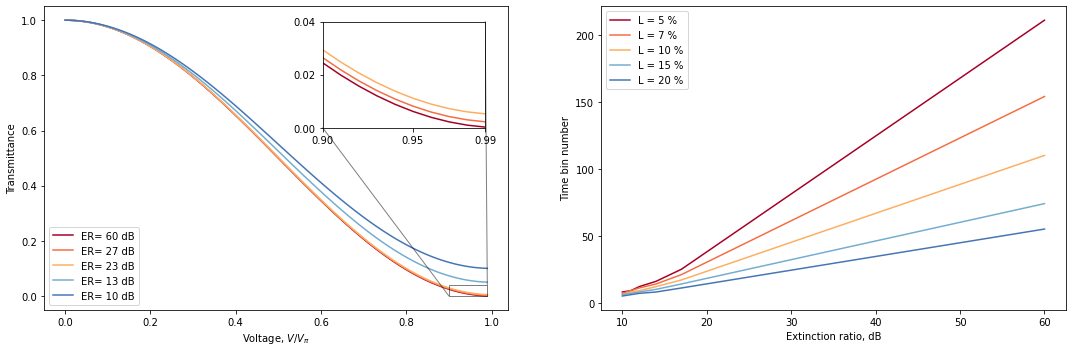

In [9]:
colors = ['#313695', '#4575b4', '#74add1', '#f46d43', '#d73027']
colors_2 = ['#a50026', '#f46d43', '#fdae61', '#74add1', '#4575b4']

ext_labels = ['0', '500:1', '200:1', '20:1', '10:1']
ext_labels_dB = ['60 dB', '27 dB', '23 dB', '13 dB', '10 dB']

V_PI = 450
extinction_ratio = 1/200
voltage = np.arange(0, V_PI, V_PI/100)
loss_arr = [0.05, 0.07, 0.1, 0.15, 0.2]
ext_arr = [1e-6, 1/500, 1/200, 1/20, 1/10]
ext_arr_max_bins = np.linspace(1e-6, 1e-1, 6)
loss_ext_max_bins = []


for j in range(len(loss_arr)): 
    max_bins = []
    for i in range(len(ext_arr_max_bins)):
        m = estimate_timebin_number(loss_arr[j], ext_arr_max_bins[i])
        max_bins.append(m)
    loss_ext_max_bins.append(max_bins)
ext_arr_dB = power_to_dB(ext_arr_max_bins, 1)    


fig, axs = plt.subplots(1,2, figsize=(15,5)) 
x1, x2, y1, y2 = 0.9, 0.99, 0, 0.04  # subregion of the original image
axins = axs[0].inset_axes(
    [0.6, 0.6, 0.35, 0.35],
    xlim=(x1, x2), ylim=(y1, y2), xticks=[0.9, 0.95, 0.99], yticks=[0, 0.02, 0.04])
for i in range(len(ext_arr)):
    tt = voltage_to_transmittance(voltage, ext_arr[i], V_PI)        
    axs[0].plot(voltage/V_PI, tt, label='ER= '+ str(ext_labels_dB[i]), color=colors_2[i], alpha=1)
    axins.plot(voltage/V_PI, tt, color=colors_2[i])
axs[0].indicate_inset_zoom(axins, edgecolor="black")
axs[0].set_xlabel(r'Voltage, $V/V_{\pi}$')
axs[0].set_ylabel('Transmittance')
axs[0].legend()


for k,v in enumerate(loss_ext_max_bins):
    axs[1].plot(ext_arr_dB, v, '-', label='L = '+str(int(100*loss_arr[k]))+' %', color=colors_2[k])
axs[1].set_xlabel('Extinction ratio, dB')
axs[1].set_ylabel('Time bin number')
axs[1].legend()
fig.tight_layout()
plt.subplots_adjust(wspace=0.2)




In [ ]:
# This code section is rather heavy on computational time, consider to reduce n_trials number to 100 to see an approximate result.
# The data on the figure below are obtained with n_trials = 100_000 for the sake of better precision,
# and further saved to txt to be available later for possible proccessing and plotting. 

n_bins = 38
n_trials = 100
err_0p1 = []
scale = 100
for i in range(1,n_bins-1):
    e = scale*estimate_intensity_error(n_bins=i, loss=0.07, ext_rt=1/200, V_PI=450, voltage_err_cents=0.1, n_trials=n_trials)
    err_0p1.append(e)

err_1 =[]

for i in range(1,n_bins-1):
    e = scale*estimate_intensity_error(n_bins=i, loss=0.07, ext_rt=1/200, V_PI=450, voltage_err_cents=1, n_trials=n_trials)
    err_1.append(e)

err_2 =[]

for i in range(1,n_bins-1):
    e = scale*estimate_intensity_error(n_bins=i, loss=0.07, ext_rt=1/200, V_PI=450, voltage_err_cents=2, n_trials=n_trials)
    err_2.append(e)

err_3 =[]

for i in range(1,n_bins-1):
    e = scale*estimate_intensity_error(n_bins=i, loss=0.07, ext_rt=1/200, V_PI=450, voltage_err_cents=3, n_trials=n_trials)
    err_3.append(e)


# Saving data to csv due to long computational time, so they are available later
np.savetxt('Mean_intensity_error_0p1c.csv', err_0p1, delimiter=';')
np.savetxt('Mean_intensity_error_1c.csv', err_1, delimiter=';')
np.savetxt('Mean_intensity_error_2c.csv', err_2, delimiter=';')
np.savetxt('Mean_intensity_error_3c.csv', err_3, delimiter=';')


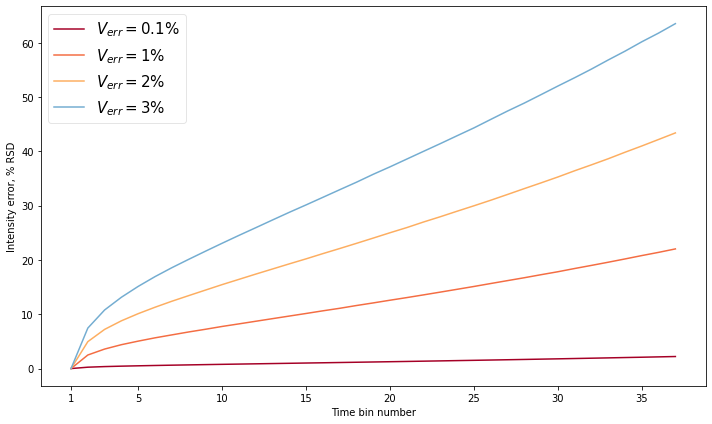

In [12]:
err_0p1 = np.loadtxt('Mean_intensity_error_0p1c.csv', delimiter=';')
err_1 = np.loadtxt('Mean_intensity_error_1c.csv', delimiter=';')
err_2 = np.loadtxt('Mean_intensity_error_2c.csv', delimiter=';')
err_3 = np.loadtxt('Mean_intensity_error_3c.csv', delimiter=';')
bins = range(1, 38)

plt.figure(figsize=(10,6))
plt.plot(bins, err_0p1, label=r'$V_{err} = 0.1\%$', markersize=7, color=colors_2[0])
plt.plot(bins, err_1, label=r'$V_{err} = 1\%$', markersize=7, color=colors_2[1])
plt.plot(bins, err_2, label=r'$V_{err} = 2\%$', markersize=7, color=colors_2[2])
plt.plot(bins, err_3, label=r'$V_{err} = 3\%$', markersize=6, color=colors_2[3])
plt.xlabel('Time bin number')
plt.ylabel(r'Intensity error, % RSD')
ticks = [1, 5, 10, 15, 20, 25, 30, 35]
plt.xticks(ticks=ticks)
plt.legend(fontsize=15, fancybox=True, framealpha=0.5)
plt.tight_layout()



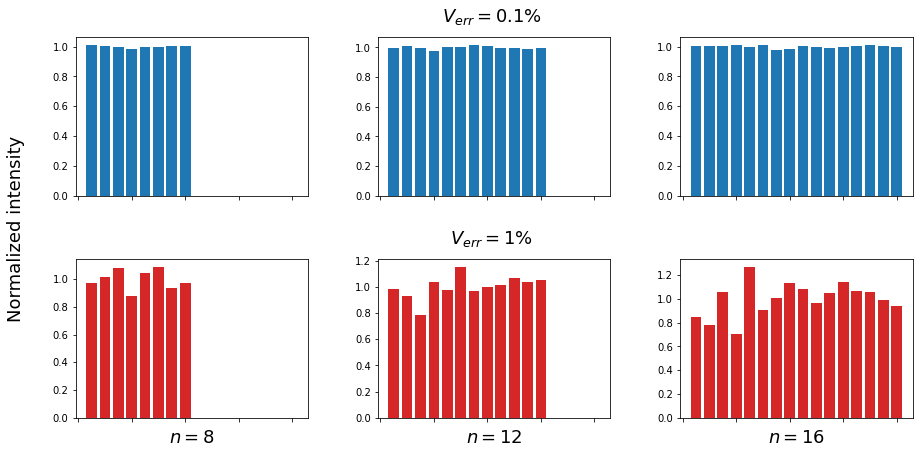

In [13]:
bins_8 = range(1,9)
bins_12 = range(1,13)
bins_16 = range(1,17)

noisy_intensity_8 = simulate_noisy_intensity(n_bins=8, loss=0.07, ext_rt=1/200, V_PI=450, voltage_err_cents=0.1)
noisy_intensity_12 = simulate_noisy_intensity(n_bins=12, loss=0.07, ext_rt=1/200, V_PI=450, voltage_err_cents=0.1)
noisy_intensity_16 = simulate_noisy_intensity(n_bins=16, loss=0.07, ext_rt=1/200, V_PI=450, voltage_err_cents=0.1)

noisy_intensity_8_1 = simulate_noisy_intensity(n_bins=8, loss=0.07, ext_rt=1/200, V_PI=450, voltage_err_cents=1)
noisy_intensity_12_1 = simulate_noisy_intensity(n_bins=12, loss=0.07, ext_rt=1/200, V_PI=450, voltage_err_cents=1)
noisy_intensity_16_1 = simulate_noisy_intensity(n_bins=16, loss=0.07, ext_rt=1/200, V_PI=450, voltage_err_cents=1)

fig, ax = plt.subplots(figsize=(15,7), nrows=2 , ncols=3, sharex=True)

ax[0,0].bar(bins_8, noisy_intensity_8, color='tab:blue')
ax[0,1].bar(bins_12, noisy_intensity_12, color='tab:blue')
ax[0,2].bar(bins_16, noisy_intensity_16, color='tab:blue')

ax[1,0].bar(bins_8, noisy_intensity_8_1, color='tab:red')
ax[1,1].bar(bins_12, noisy_intensity_12_1, color='tab:red')
ax[1,2].bar(bins_16, noisy_intensity_16_1, color='tab:red')

ax[1,0].set_xlabel(r'$n = 8$', fontsize=18)
ax[1,1].set_xlabel(r'$n = 12$', fontsize=18)
ax[1,2].set_xlabel(r'$n = 16$', fontsize=18)

ticks = [0, 4, 8, 12, 16]
labels = [" ", " ", " ", " ", " ",]
ax[0,1].set_xticks(ticks, labels='')

fig.text(0.51, 0.92, r'$V_{err} = 0.1\%$', ha='center', va='center', fontsize=18)
fig.text(0.51, 0.48, r'$V_{err} = 1\%$', ha='center', va='center', fontsize=18)
fig.text(0.07, 0.5, 'Normalized intensity', ha='center', va='center', rotation='vertical', fontsize=18)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.4)


